In [118]:
import numpy as np
from scipy.fft import fft2, ifft2
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, eye, csr_matrix
from scipy.sparse.linalg import spsolve, bicgstab, gmres
from scipy.linalg import lu, solve_triangular
import time

dx = dy =  0.3125
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(4096, 4096)

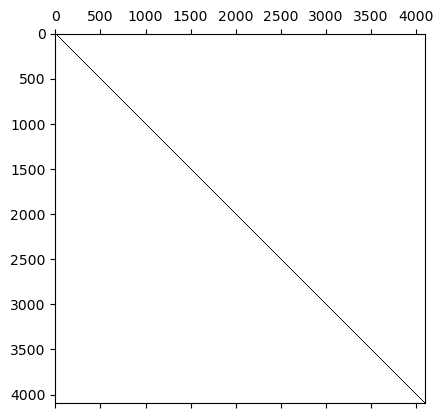

In [136]:
import numpy as np
from scipy.sparse import spdiags, kron, eye
import matplotlib.pyplot as plt

# Step 1: Define the Grid Parameters
n = 64  # Number of grid points in each dimension
x = np.linspace(-10, 10, n)  # Spatial domain for x
y = np.linspace(-10, 10, n)  # Spatial domain for y
dx = x[1] - x[0]  # Grid spacing in x-direction
dy = y[1] - y[0]  # Grid spacing in y-direction

# Ensure dx and dy are equal (uniform grid)
dx = (x[-1] - x[0]) / (n)
dy = dx
print("dx = dy = ", dx)

# Step 2: Create the 1D Derivative Matrices with Periodic Boundary Conditions

# Second Derivative Operator (Dxx and Dyy)
e = np.ones(n)  # Vector of ones
main_diag = -2 * e / dx**2  # Main diagonal
off_diag = e / dx**2  # Off-diagonals

# Create the sparse matrix for Dxx
data = np.array([off_diag, main_diag, off_diag])
offsets = np.array([-1, 0, 1])
Dxx = spdiags(data, offsets, n, n, format='csr')

# Adjust for periodic boundary conditions
Dxx = Dxx.tolil()
Dxx[0, -1] = 1 / dx**2  # Wrap-around from first to last
Dxx[-1, 0] = 1 / dx**2  # Wrap-around from last to first
Dxx = Dxx.tocsr()

# Dyy is identical to Dxx in this case
Dyy = Dxx.copy()

# First Derivative Operator (D_x and D_y)
lower_diag = -e / (2 * dx)
upper_diag = e / (2 * dx)

data = np.array([lower_diag, upper_diag])
offsets = np.array([-1, 1])
D_x = spdiags(data, offsets, n, n, format='csr')

# Adjust for periodic boundary conditions
D_x = D_x.tolil()
D_x[0, -1] = -1 / (2 * dx)  # Wrap-around from first to last
D_x[-1, 0] = 1 / (2 * dx)   # Wrap-around from last to first
D_x = D_x.tocsr()

# D_y is identical to D_x in this case
D_y = D_x.copy()

# Step 3: Construct the 2D Operators Using Kronecker Products

# Identity matrix of size n
I_n = eye(n, format='csr')

# Laplacian operator in 2D (Matrix A1)
A = kron(I_n, Dxx) + kron(Dyy, I_n).toarray()
A[0,0] /= -2

# First derivative operator in x-direction (Matrix A2)
C = kron(I_n, D_x).toarray()

# First derivative operator in y-direction (Matrix A3)
B = kron(D_y, I_n).toarray()

# The matrices A1, A2, and A3 are now ready to use

plt.spy(A)
print(B)
#plt.show()
## print the A1 in matrix form
#print("matrix A1:")
#print(A1.toarray())
#plt.spy(A2)
#plt.show()
#print("matrix A2:")
#print(A2.toarray())
#
#plt.spy(A3)
#plt.show()
#print("matrix A3:")
#print(A3.toarray())
#print(A3.toarray()[0,:])
A.shape

In [119]:
# Parameters
n = 64  # Number of grid points
x_min, x_max = -10, 10  # Spatial domain in x
y_min, y_max = -10, 10  # Spatial domain in y
nu = 0.001  # Viscosity
t_span = (0, 4)  # Time span for integration
#t_span = (0, 10)
t_eval = np.arange(0, 4.5, 0.5)  # Time evaluation points
#t_eval = np.arange(0, 10.5, 0.5)
print(t_eval)

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]


In [120]:
# Spatial grid
x = np.linspace(x_min, x_max, n, endpoint=False)
y = np.linspace(y_min, y_max, n, endpoint=False)
dx = (x_max - x_min) / n
dy = (y_max - y_min) / n
X, Y = np.meshgrid(x, y, indexing='ij')

# Initial vorticity (elliptical Gaussian)
omega0 = np.exp(-X**2 - Y**2 / 20)
omega0_flat = omega0.flatten()

In [121]:
omega0.shape

(64, 64)

In [122]:
# Wavenumber grids for FFT
kx = np.fft.fftfreq(n, d=(x_max - x_min) / n) * 2 * np.pi
ky = np.fft.fftfreq(n, d=(y_max - y_min) / n) * 2 * np.pi
kx[0] = 1e-6  # Avoid division by zero
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky, indexing='ij')
K2 = KX**2 + KY**2
K2[0, 0] = 1e-6  # Avoid division by zero at (0,0)

In [123]:
def compute_streamfunction(omega):
    """Compute the streamfunction ψ from vorticity ω using FFT."""
    omega_hat = fft2(omega)
    psi_hat = omega_hat / (-K2)
    psi_hat[0, 0] = 0  # Enforce zero mean for ψ
    psi = np.real(ifft2(psi_hat))
    return psi

def rhs(t, omega_flat):
    """Compute the right-hand side of the vorticity equation."""
    omega = omega_flat.reshape((n, n))

    # Compute streamfunction ψ
    psi = compute_streamfunction(omega)
    
    # Compute derivatives using spectral methods
    omega_hat = fft2(omega)
    psi_hat = fft2(psi)

    # Compute derivatives in Fourier space
    omega_x_hat = 1j * KX * omega_hat
    omega_y_hat = 1j * KY * omega_hat
    psi_x_hat = 1j * KX * psi_hat
    psi_y_hat = 1j * KY * psi_hat

    # Transform back to physical space
    omega_x = np.real(ifft2(omega_x_hat))
    omega_y = np.real(ifft2(omega_y_hat))
    psi_x = np.real(ifft2(psi_x_hat))
    psi_y = np.real(ifft2(psi_y_hat))

    # Compute Jacobian [ψ, ω]
    J = psi_x * omega_y - psi_y * omega_x

    # Compute Laplacian of ω using spectral methods
    laplacian_omega_hat = -K2 * omega_hat
    laplacian_omega = np.real(ifft2(laplacian_omega_hat))

    # RHS of the vorticity equation
    domega_dt = -J + nu * laplacian_omega

    return domega_dt.flatten()

In [ ]:
def spc_rhs(t, wt2, nx, ny, N, KX, KY, K, nu, A, B, C):
    
    wt = wt2.reshape((nx, ny))
    wtfft = fft2(wt)
    psix = np.real(ifft2(-wtfft / K)).flatten()
    rhs = (nu * (A @ wt2) + (B @ wt2) * (C @ psix) - (B @ psix) * (C @ wt2))
    
    return rhs

In [129]:
def rhs(t, omega_flat,A, B, C):
    omega = omega_flat.reshape((n, n))
    # Compute streamfunction ψ
    psi = compute_streamfunction(omega)
    
    # Compute gradients using spectral methods
    omega_hat = fft2(omega)
    psi_hat = fft2(psi)
    omega_x = np.real(ifft2(1j * KX * omega_hat))
    omega_y = np.real(ifft2(1j * KY * omega_hat))
    psi_x = np.real(ifft2(1j * KX * psi_hat))
    psi_y = np.real(ifft2(1j * KY * psi_hat))

    # Compute the terms similar to B*phi, C*w3, etc.
    B_phi = psi_x.flatten()
    C_w3 = omega_y.flatten()
    C_phi = psi_y.flatten()
    B_w3 = omega_x.flatten()
    A_w3 = omega_flat  # Identity operation or Laplacian term

    term1 = -B * psi
    term2 = C_phi * B
    term3 = nu * (A @ omega_flat)

    domega_dt = term1 + term2 + term3

    return domega_dt

In [130]:
# Integrate in time using solve_ivp
sol = solve_ivp(rhs, t_span, omega0_flat, t_eval=t_eval, method='RK45')

# Extract the solution for vorticity at each time step
A1 = sol.y  # A1 has shape (n*n, number of time steps)

In [131]:
A1

array([[ 2.50656748e-46, -6.30823285e-33, -1.16511632e-32, ...,
        -2.22732155e-32, -7.42430448e-33, -2.22450407e-32],
       [ 3.40938344e-46, -1.02357794e-13,  9.17487663e-15, ...,
         8.68495031e-12,  5.80545571e-11,  1.13884887e-10],
       [ 4.59230937e-46,  4.33764503e-13, -7.32898430e-14, ...,
        -3.58096645e-11, -2.38606911e-10, -4.61355281e-10],
       ...,
       [ 2.87789014e-43,  1.87586214e-12, -1.86574318e-12, ...,
        -2.97665827e-10, -8.01584113e-10, -7.18881187e-10],
       [ 2.15754607e-43, -1.00289623e-12,  9.97723346e-13, ...,
         1.71163134e-10,  3.88930867e-10,  2.19564507e-10],
       [ 1.60178709e-43,  4.20024862e-13, -5.08438391e-13, ...,
        -7.70433291e-11, -1.28093313e-10,  3.23475594e-11]])

In [127]:
A1[1950:2050,:]

array([[0.66354656, 0.69533641, 0.72939814, 0.76490297, 0.80079465,
        0.83582344, 0.8685032 , 0.89680258, 0.91971804],
       [0.67333802, 0.69067697, 0.71100739, 0.73408858, 0.75954577,
        0.78668151, 0.8147499 , 0.843464  , 0.87080113],
       [0.67663385, 0.67862343, 0.68391544, 0.69242308, 0.70417818,
        0.71923089, 0.73736428, 0.75745258, 0.78083525],
       [0.67333802, 0.65986151, 0.64965619, 0.64289144, 0.63958697,
        0.63970362, 0.64344045, 0.65182969, 0.66217977],
       [0.66354656, 0.63521949, 0.61003922, 0.58814154, 0.56984112,
        0.55533245, 0.54450449, 0.53652379, 0.53490978],
       [0.64754285, 0.60566288, 0.56685572, 0.53171183, 0.50008606,
        0.47220538, 0.4483432 , 0.42902388, 0.41070445],
       [0.62578401, 0.57231588, 0.52189528, 0.47542041, 0.43330462,
        0.39581672, 0.36236642, 0.33265917, 0.30900975],
       [0.59887923, 0.53610443, 0.47666427, 0.42218911, 0.37247703,
        0.32812319, 0.28967769, 0.25589536, 0.22508037],


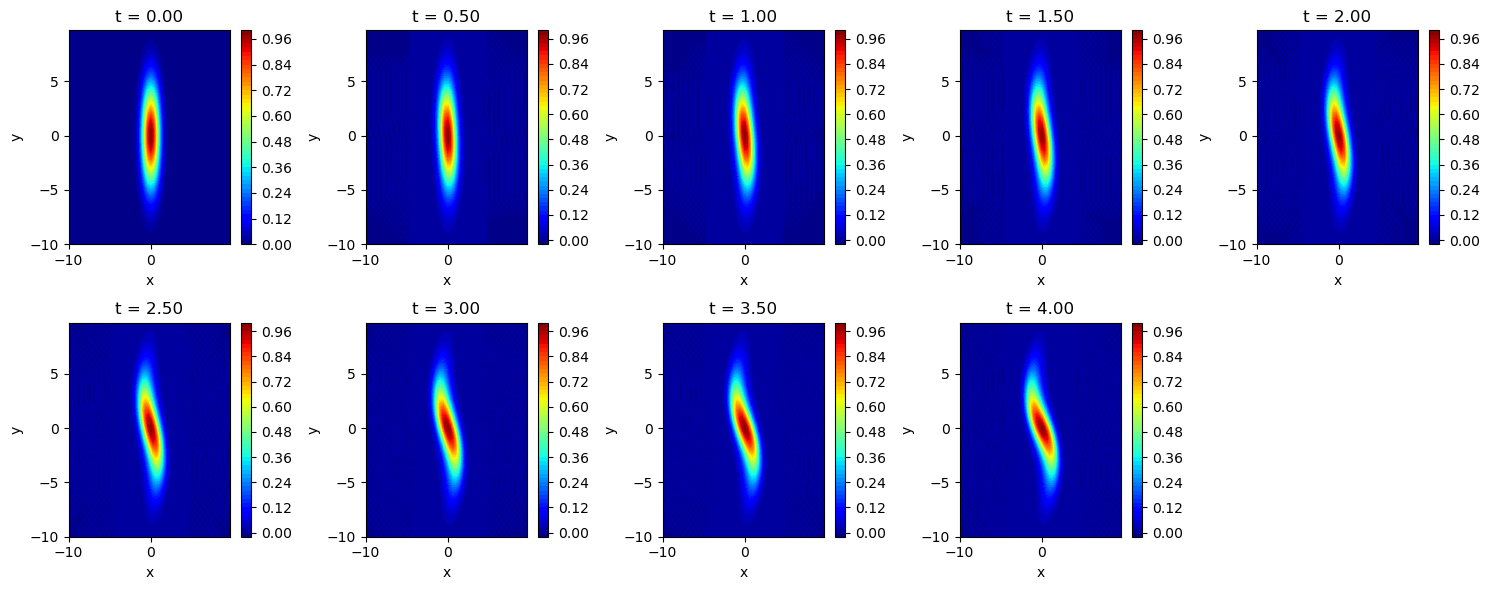

In [75]:
# Plotting the vorticity at different time steps
num_plots = len(t_eval)
fig, axes = plt.subplots(2, int(np.ceil(num_plots / 2)), figsize=(15, 6))

# Plotting the vorticity at different time steps
#num_plots = len(t_eval)
#rows = 4  # Number of rows in the grid
#cols = int(np.ceil(num_plots / rows))  # Number of columns in the grid

#fig, axes = plt.subplots(rows, cols, figsize=(18, 10))  # Adjust the figure size

for i, ax in enumerate(axes.flatten()):
    if i < num_plots:
        omega_t = A1[:, i].reshape((n, n))
        c = ax.contourf(X, Y, omega_t, levels=50, cmap='jet')
        ax.set_title(f't = {t_eval[i]:.2f}')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        fig.colorbar(c, ax=ax)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

## Part B
- A/b
- LU decomposition
- BICGSTAB
- GMRES

In [18]:
# Parameters
n = 64  # Number of grid points in each dimension
x_min, x_max = -10, 10  # Spatial domain in x
y_min, y_max = -10, 10  # Spatial domain in y
nu = 0.001  # Viscosity
t_span = (0, 4)  # Time span for integration
t_eval = np.arange(0, 4.5, 0.5)  # Time evaluation points

In [19]:

# Spatial grid
x = np.linspace(x_min, x_max, n, endpoint=False)
y = np.linspace(y_min, y_max, n, endpoint=False)
dx = (x_max - x_min) / n
dy = (y_max - y_min) / n
X, Y = np.meshgrid(x, y, indexing='ij')

# Initial vorticity (elliptical Gaussian)
omega0 = np.exp(-X**2 - Y**2 / 20)
omega0_flat = omega0.flatten()


In [35]:
# Construct Laplacian operator A with periodic boundary conditions
def construct_laplacian(n, dx):
    diagonals = [-2 * np.ones(n), np.ones(n - 1), np.ones(n - 1)]
    offsets = [0, -1, 1]
    lap1d = diags(diagonals, offsets, shape=(n, n), format='csr')
    lap1d = lap1d / dx**2

    # Periodic boundary conditions
    lap1d = lap1d.tolil()
    lap1d[0, -1] = 1 / dx**2
    lap1d[-1, 0] = 1 / dx**2
    lap1d = lap1d.tocsr()

    I = eye(n, format='csr')
    A = kron(lap1d, I) + kron(I, lap1d)
    return A

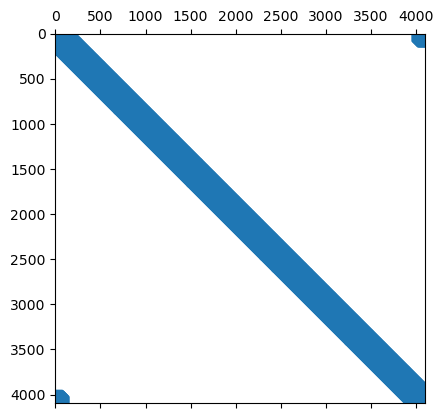

In [76]:

# Laplacian operator
A = construct_laplacian(n, dx)
A = A.tocsr()

# Adjust A(0,0) as per the instructions
A = A.tolil()
A[0, 0] = 2  # Set A(0,0) = 2 instead of -4
A = A.tocsr()

# Convert A to dense matrix for LU decomposition
A_dense = A.toarray()
plt.spy(A)

In [78]:
print(A)

  (0, 0)	2.0
  (0, 1)	10.24
  (0, 63)	10.24
  (0, 64)	10.24
  (0, 4032)	10.24
  (1, 0)	10.24
  (1, 1)	-40.96
  (1, 2)	10.24
  (1, 65)	10.24
  (1, 4033)	10.24
  (2, 1)	10.24
  (2, 2)	-40.96
  (2, 3)	10.24
  (2, 66)	10.24
  (2, 4034)	10.24
  (3, 2)	10.24
  (3, 3)	-40.96
  (3, 4)	10.24
  (3, 67)	10.24
  (3, 4035)	10.24
  (4, 3)	10.24
  (4, 4)	-40.96
  (4, 5)	10.24
  (4, 68)	10.24
  (4, 4036)	10.24
  :	:
  (4091, 59)	10.24
  (4091, 4027)	10.24
  (4091, 4090)	10.24
  (4091, 4091)	-40.96
  (4091, 4092)	10.24
  (4092, 60)	10.24
  (4092, 4028)	10.24
  (4092, 4091)	10.24
  (4092, 4092)	-40.96
  (4092, 4093)	10.24
  (4093, 61)	10.24
  (4093, 4029)	10.24
  (4093, 4092)	10.24
  (4093, 4093)	-40.96
  (4093, 4094)	10.24
  (4094, 62)	10.24
  (4094, 4030)	10.24
  (4094, 4093)	10.24
  (4094, 4094)	-40.96
  (4094, 4095)	10.24
  (4095, 63)	10.24
  (4095, 4031)	10.24
  (4095, 4032)	10.24
  (4095, 4094)	10.24
  (4095, 4095)	-40.96


In [80]:
# Function to solve for psi using different methods
def solve_streamfunction(omega_flat, method='direct'):
    b = omega_flat.copy()
    if method == 'direct':
        start_time = time.time()
        psi_flat = spsolve(A, b)
        elapsed_time = time.time() - start_time
    elif method == 'LU':
        # LU decomposition using scipy.linalg.lu
        start_time = time.time()
        P, L, U = lu(A_dense)
        # Solve Ax = b using forward and backward substitution
        Pb = np.dot(P, b)
        y = solve_triangular(L, Pb, lower=True)
        psi_flat = solve_triangular(U, y)
        elapsed_time = time.time() - start_time
    elif method == 'BiCGSTAB':
        start_time = time.time()
        psi_flat, info = bicgstab(A, b, tol=1e-6, maxiter=1000)
        elapsed_time = time.time() - start_time
        if info != 0:
            print(f"BiCGSTAB did not converge within the maximum number of iterations (info={info})")
    elif method == 'GMRES':
        start_time = time.time()
        psi_flat, info = gmres(A, b, tol=1e-6, restart=50, maxiter=1000)
        elapsed_time = time.time() - start_time
        if info != 0:
            print(f"GMRES did not converge within the maximum number of iterations (info={info})")
    else:
        raise ValueError("Unknown method")
    return psi_flat.reshape((n, n)), elapsed_time

In [81]:
# Lists to store computational times
times = {
    'direct': [],
    'LU': [],
    'BiCGSTAB': [],
    'GMRES': []
}

# Initialize lists to store residuals
residuals = {
    'BiCGSTAB': [],
    'GMRES': []
}

In [82]:
# Callback functions to store residuals
def bicgstab_callback(rk):
    residuals['BiCGSTAB'].append(np.linalg.norm(rk))

def gmres_callback(rk):
    residuals['GMRES'].append(np.linalg.norm(rk))

# Function to compute the RHS of the vorticity equation
def rhs(t, omega_flat):
    """Compute the right-hand side of the vorticity equation."""
    omega = omega_flat.reshape((n, n))

    # Solve for streamfunction ψ
    psi, elapsed_time = solve_streamfunction(omega_flat, method=method)

    # Store computational times
    times[method].append(elapsed_time)

    # Compute derivatives using finite differences with periodic boundaries
    omega_roll_xp = np.roll(omega, -1, axis=0)
    omega_roll_xm = np.roll(omega, 1, axis=0)
    omega_roll_yp = np.roll(omega, -1, axis=1)
    omega_roll_ym = np.roll(omega, 1, axis=1)

    psi_roll_xp = np.roll(psi, -1, axis=0)
    psi_roll_xm = np.roll(psi, 1, axis=0)
    psi_roll_yp = np.roll(psi, -1, axis=1)
    psi_roll_ym = np.roll(psi, 1, axis=1)

    omega_x = (omega_roll_xp - omega_roll_xm) / (2 * dx)
    omega_y = (omega_roll_yp - omega_roll_ym) / (2 * dy)
    psi_x = (psi_roll_xp - psi_roll_xm) / (2 * dx)
    psi_y = (psi_roll_yp - psi_roll_ym) / (2 * dy)

    # Compute Jacobian [ψ, ω]
    J = psi_x * omega_y - psi_y * omega_x

    # Compute Laplacian of ω using finite differences
    laplacian_omega = (omega_roll_xp + omega_roll_xm + omega_roll_yp + omega_roll_ym - 4 * omega) / dx**2

    # RHS of the vorticity equation
    domega_dt = -J + nu * laplacian_omega

    return domega_dt.flatten()


In [83]:
# Run the simulation for different methods
methods = ['direct', 'LU', 'BiCGSTAB', 'GMRES']
results = {}

In [84]:
for method in methods:
    print(f"\nRunning simulation with method: {method}")
    times[method] = []
    residuals['BiCGSTAB'] = []
    residuals['GMRES'] = []

    # For iterative methods, set up callback functions
    if method == 'BiCGSTAB':
        solve_streamfunction_callback = bicgstab_callback
    elif method == 'GMRES':
        solve_streamfunction_callback = gmres_callback
    else:
        solve_streamfunction_callback = None

    # Integrate in time using solve_ivp
    sol = solve_ivp(rhs, t_span, omega0_flat, t_eval=t_eval, method='RK45')

    # Store the results
    results[method] = sol.y.copy()

    # After the first few solves, plot residuals for iterative methods
    if method in ['BiCGSTAB', 'GMRES'] and residuals[method]:
        plt.figure()
        plt.semilogy(residuals[method], label=f'{method} Residuals')
        plt.xlabel('Iteration')
        plt.ylabel('Residual')
        plt.title(f'{method} Residuals Over Time')
        plt.legend()
        plt.grid()
        plt.show()


Running simulation with method: direct

Running simulation with method: LU

Running simulation with method: BiCGSTAB


/var/folders/38/3vfcth493232cphvml_jy4k80000gn/T/ipykernel_1963/1872267553.py:19: DeprecationWarning: 'scipy.sparse.linalg.bicgstab' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  psi_flat, info = bicgstab(A, b, tol=1e-6, maxiter=1000)



Running simulation with method: GMRES


/var/folders/38/3vfcth493232cphvml_jy4k80000gn/T/ipykernel_1963/1872267553.py:25: DeprecationWarning: 'scipy.sparse.linalg.gmres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  psi_flat, info = gmres(A, b, tol=1e-6, restart=50, maxiter=1000)


In [85]:
# Extract the solutions
A2 = results['direct']  # For A\b method
A3 = results['LU']      # For LU decomposition method

In [86]:
# Print average computational times
for method in methods:
    avg_time = np.mean(times[method])
    print(f"Average computational time per solve for {method}: {avg_time:.6f} seconds")

Average computational time per solve for direct: 0.016884 seconds
Average computational time per solve for LU: 0.674193 seconds
Average computational time per solve for BiCGSTAB: 0.032277 seconds
Average computational time per solve for GMRES: 0.237727 seconds


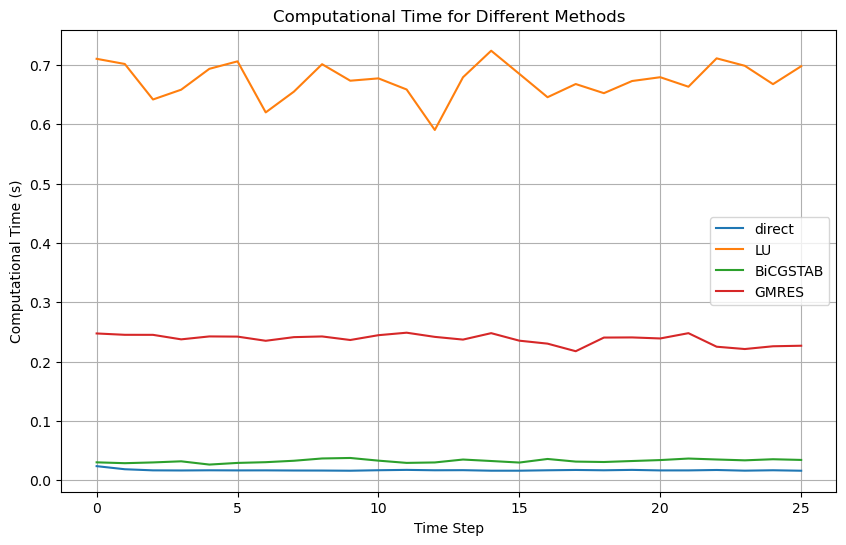

In [87]:
# Plot computational times
plt.figure(figsize=(10, 6))
for method in methods:
    plt.plot(times[method], label=method)
plt.xlabel('Time Step')
plt.ylabel('Computational Time (s)')
plt.title('Computational Time for Different Methods')
plt.legend()
plt.grid()
plt.show()

In [92]:
A2.reshape(64,64,9)

array([[[ 2.50656748e-46, -1.79143643e-36,  1.02919934e-36, ...,
         -5.80790330e-26, -6.68913647e-25,  3.01695099e-24],
        [ 3.40938344e-46,  2.26090724e-29, -1.85609482e-29, ...,
          1.48213085e-19,  7.82137979e-19, -1.67416661e-18],
        [ 4.59230937e-46, -3.60520815e-29,  3.08455885e-29, ...,
         -2.63163014e-20, -2.95796889e-19,  1.28008379e-18],
        ...,
        [ 6.12555255e-46,  1.45504499e-29, -1.58786717e-29, ...,
          1.53207202e-20,  1.35149042e-19, -7.02887362e-19],
        [ 4.59230937e-46, -3.60520815e-29,  3.08455885e-29, ...,
         -2.63163014e-20, -2.95796889e-19,  1.28008379e-18],
        [ 3.40938344e-46,  2.26090724e-29, -1.85609482e-29, ...,
          1.48213085e-19,  7.82137979e-19, -1.67416661e-18]],

       [[ 1.17762859e-43, -2.26093387e-29,  1.85614646e-29, ...,
         -1.48306461e-19, -7.82424220e-19,  1.67449651e-18],
        [ 1.60178709e-43,  8.91699185e-30, -5.99655105e-30, ...,
          1.18677202e-20,  4.33615853e